In [1]:
import reproducibility

setting TF_DETERMINISTIC_OPS=1 PYTHONHASHSEED=0


2023-04-21 23:52:56.961796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


resetting random seed do 123
call set_seed() or set_seed(seed=value) to reset


In [2]:
# both can change
# Environment
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.utils.vis_utils import plot_model
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
import pickle, os
from utils import hash2

# Local modules for handling data and running moisture models
import data_funcs as datf
from data_funcs import format_raws, retrieve_raws, format_precip, fixnan
from data_funcs import raws_data, synthetic_data, plot_data, check_data, mse_data, to_json, from_json
import moisture_models as mod
from moisture_rnn import create_RNN_2, staircase, create_rnn_data, train_rnn, rnn_predict

meso_token="b40cb52cbdef43ef81329b84e8fd874f"


In [3]:
# Change directory for data read/write
os.chdir('data')

## Retrieve Data

In [4]:
# read test datasets
# case_data = from_json('rnn_orig.json')
filename = 'testing_dict.pickle'
with open(filename, 'rb') as handle:
    test_dict = pickle.load(handle)
    for case in test_dict:
        test_dict[case]['case'] = case
        test_dict[case]['filename'] = filename


In [5]:
case = 'case11'    # choose a test dataset

In [6]:
raws_dat = test_dict[case]
case_data=raws_dat
check_data(case_data)
hours=raws_dat['hours']
h2=raws_dat['h2'] 

filename = testing_dict.pickle   <class 'str'>
title = RNN Orig   <class 'str'>
note not present
hours = 854   <class 'int'>
h2 = 300   <class 'int'>
case = case11   <class 'str'>
E not present
array Ed drying equilibrium (%) length 854 min 1.6557478175353315 max 17.076346687085564 hash 14064772575994390991 <class 'numpy.ndarray'>
array Ew wetting equilibrium (%) length 854 min 1.0385669966012008 max 15.646159240682982 hash 11355699882015093850 <class 'numpy.ndarray'>
Ec not present
array rain rain intensity (mm/h) length 854 min 0.0 max 0.0 hash 0 <class 'numpy.ndarray'>
array fm RAWS fuel moisture data (%) length 854 min 1.6 max 8.1 hash 9476624128859380674 <class 'numpy.ndarray'>
m not present


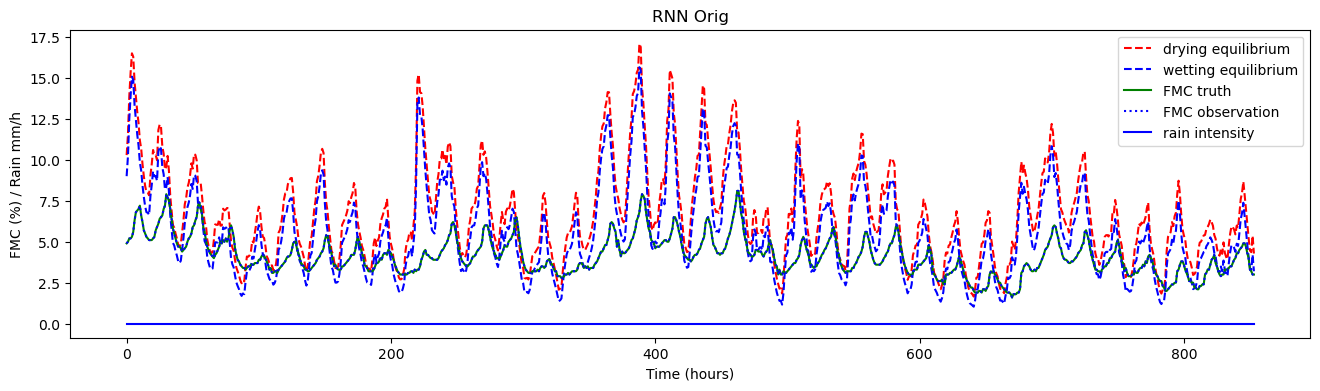

In [7]:
%matplotlib inline
plot_data(raws_dat)

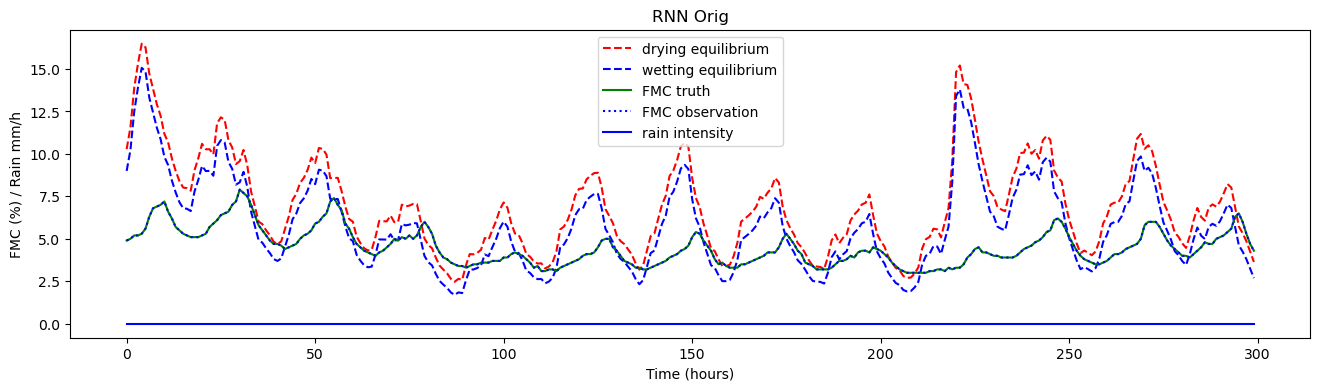

In [8]:
plot_data(raws_dat,hmax=h2)

In [9]:
%matplotlib inline
if 0:
    synt_dat=synthetic_data()  # just testinh
    check_data(raws_dat)
    plot_data(synt_dat)

In [10]:
# dictionary raws_dat has all that is needed for the run 
# keeping the name raws_dat for now even if it may not be raws data



## Fit Augmented KF

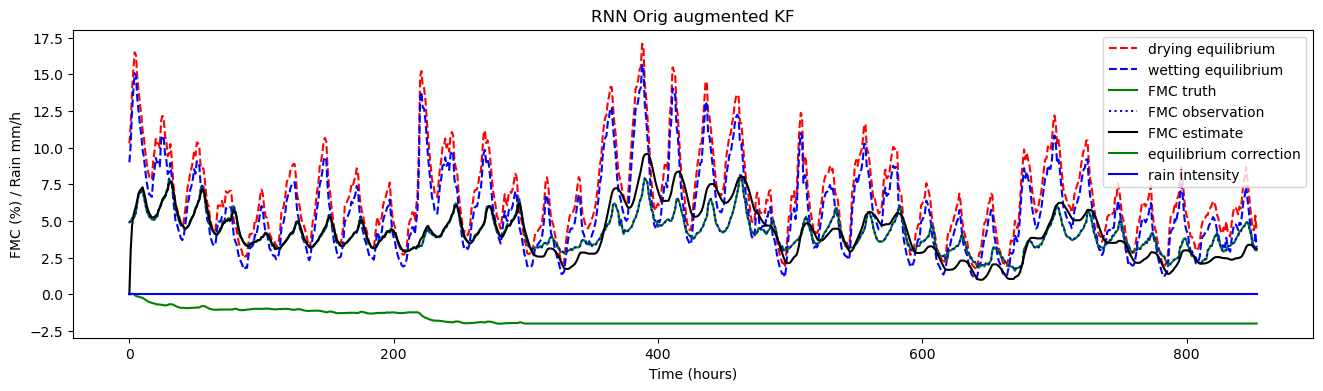

In [11]:
m,Ec = mod.run_augmented_kf(raws_dat)  # extract from state
raws_dat['m']=m
raws_dat['Ec']=Ec
plot_data(raws_dat,title2='augmented KF')

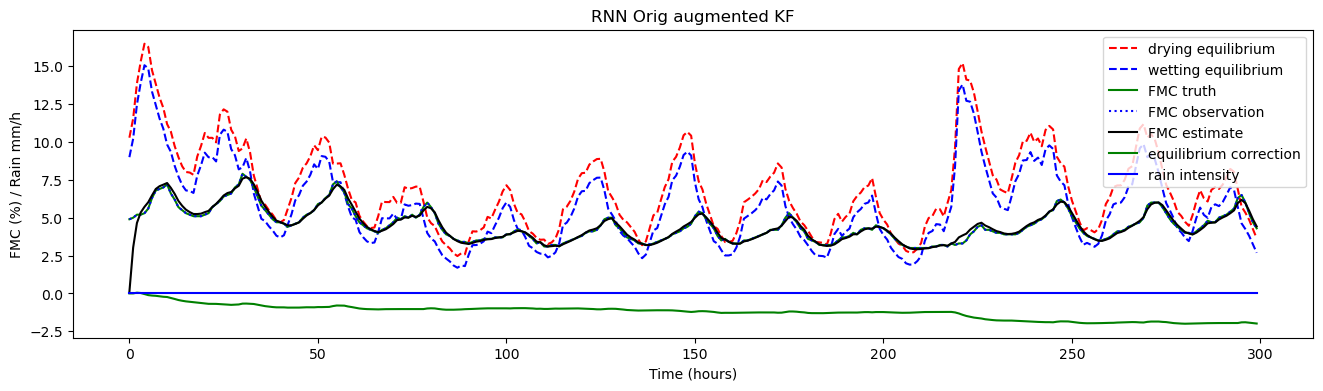

In [12]:
plot_data(raws_dat,hmin=0,hmax=h2,title2='augmented KF')

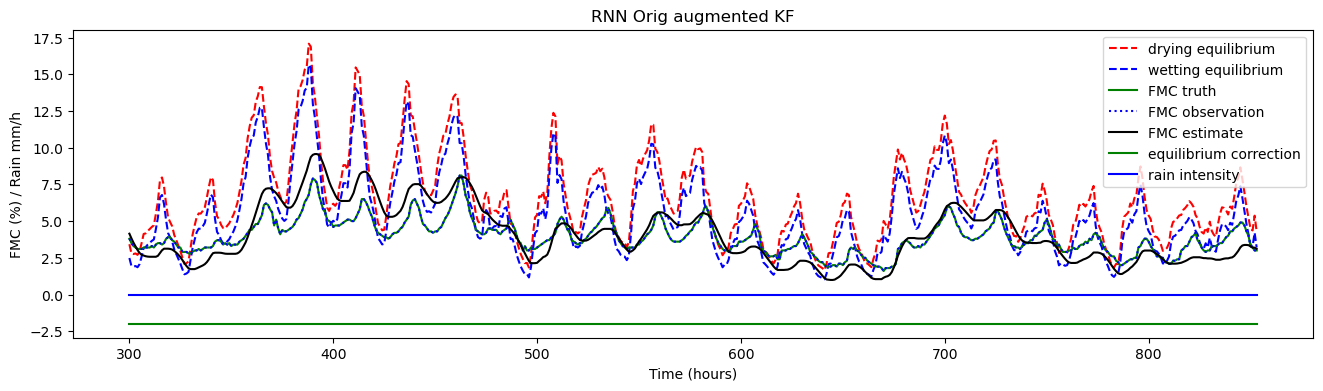

In [13]:
plot_data(raws_dat,hmin=h2,hmax=hours,title2='augmented KF')

In [14]:
mse_data(raws_dat) 


Training MSE:   0.1092
Prediction MSE: 1.2065


## Fit RNN Model

In [15]:
# Set seed for reproducibility
reproducibility.set_seed()

resetting random seed do 123


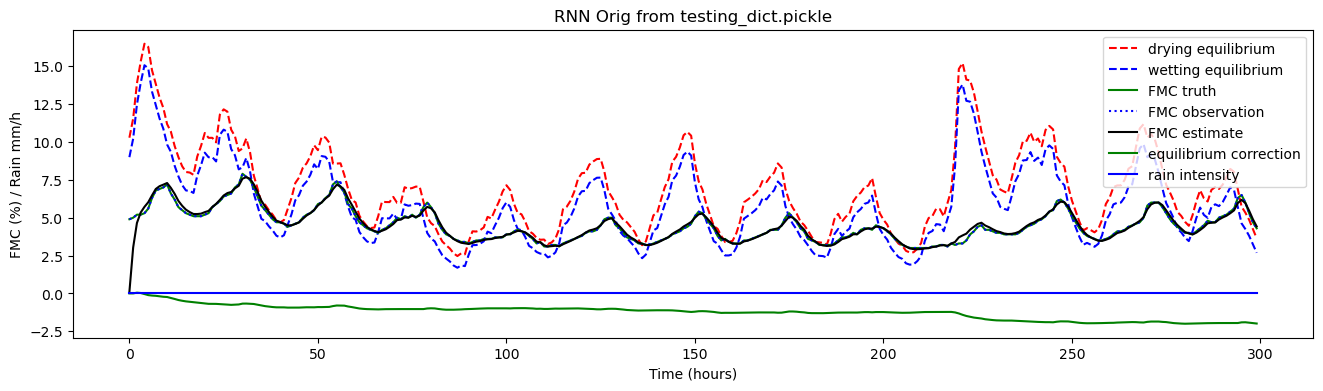

In [16]:
plot_data(case_data,title2='from testing_dict.pickle',hmin=0,hmax=h2)

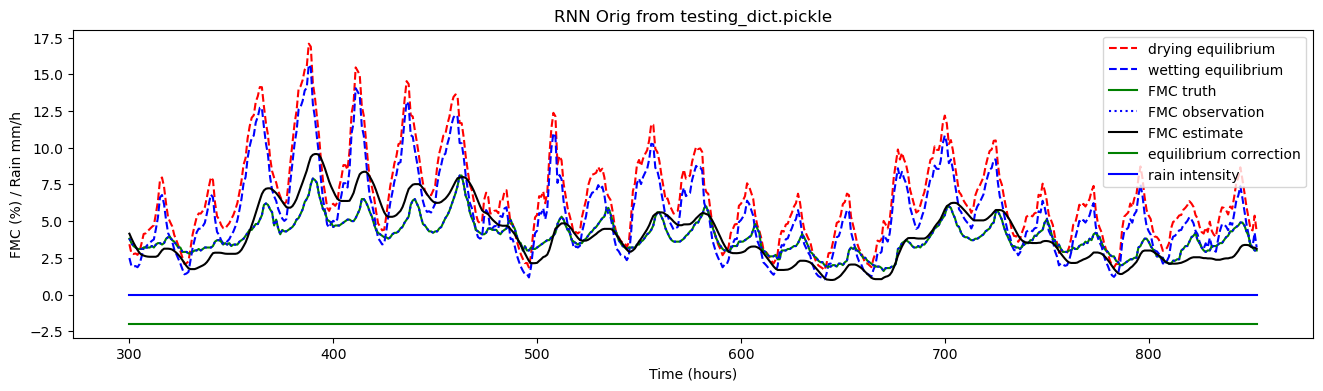

In [17]:
plot_data(case_data,title2='from testing_dict.pickle',hmin=h2,hmax=hours)

In [18]:
if 'm' in case_data:
    mse_data(case_data)  # just check sdolution if there
    del case_data['m']   # cleanup - remove old solution if any

Training MSE:   0.1092
Prediction MSE: 1.2065


In [19]:
verbose = False
# Set seed for reproducibility
reproducibility.set_seed()
rnn_dat = create_rnn_data(case_data,scale=False, verbose=verbose)

resetting random seed do 123


2023-04-21 23:53:07.187592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
## Check 1: equilibrium input data the same

print(hash2(rnn_dat['Et']))
print(hash2(rnn_dat['x_train']))
print(hash2(rnn_dat['y_train']))

6973728384299933225
9270893620491725179
10119650379183749962


In [21]:
model_predict = train_rnn(
    rnn_dat,
    rnn_dat['hours'],
    activation=['linear','linear'],
    hidden_units=6,
    dense_units=1,
    dense_layers=1,
    verbose = verbose
)

Function: moisture_rnn.create_RNN_2
Arguments:
  hidden_units = 6
  dense_units = 1
  activation = ['linear', 'linear']
  stateful = True
  batch_shape = (296, 5, 2)
  input_shape = None
  dense_layers = 1
  rnn_layers = 1
  return_sequences = False
  initial_state = None
  verbose = True
Function: moisture_rnn.create_RNN_2
Arguments:
  hidden_units = 6
  dense_units = 1
  activation = ['linear', 'linear']
  stateful = False
  batch_shape = None
  input_shape = (854, 2)
  dense_layers = 1
  rnn_layers = 1
  return_sequences = True
  initial_state = None
  verbose = True


In [22]:
m = rnn_predict(model_predict, rnn_dat, rnn_dat['hours'], verbose = verbose)
case_data['m'] = m
note = 'm replaced by a solution from fmda_rnn_rain'
if 'note' in case_data:
    case_data['note'] = case_data['note'] + '\n' + note
else:
    case_data['note'] = note
check_data(case_data)

filename = testing_dict.pickle   <class 'str'>
title = RNN Orig   <class 'str'>
note = m replaced by a solution from fmda_rnn_rain   <class 'str'>
hours = 854   <class 'int'>
h2 = 300   <class 'int'>
case = case11   <class 'str'>
E not present
array Ed drying equilibrium (%) length 854 min 1.6557478175353315 max 17.076346687085564 hash 14064772575994390991 <class 'numpy.ndarray'>
array Ew wetting equilibrium (%) length 854 min 1.0385669966012008 max 15.646159240682982 hash 11355699882015093850 <class 'numpy.ndarray'>
array Ec equilibrium equilibrium (%) length 854 min -2.0021484495502215 max 0.04713980095609851 hash 15903472541915324941 <class 'numpy.ndarray'>
array rain rain intensity (mm/h) length 854 min 0.0 max 0.0 hash 0 <class 'numpy.ndarray'>
array fm RAWS fuel moisture data (%) length 854 min 1.6 max 8.1 hash 9476624128859380674 <class 'numpy.ndarray'>
array m fuel moisture estimate (%) length 854 min -0.5283096 max 7.471472 hash 380442441424371125 <class 'numpy.ndarray'>


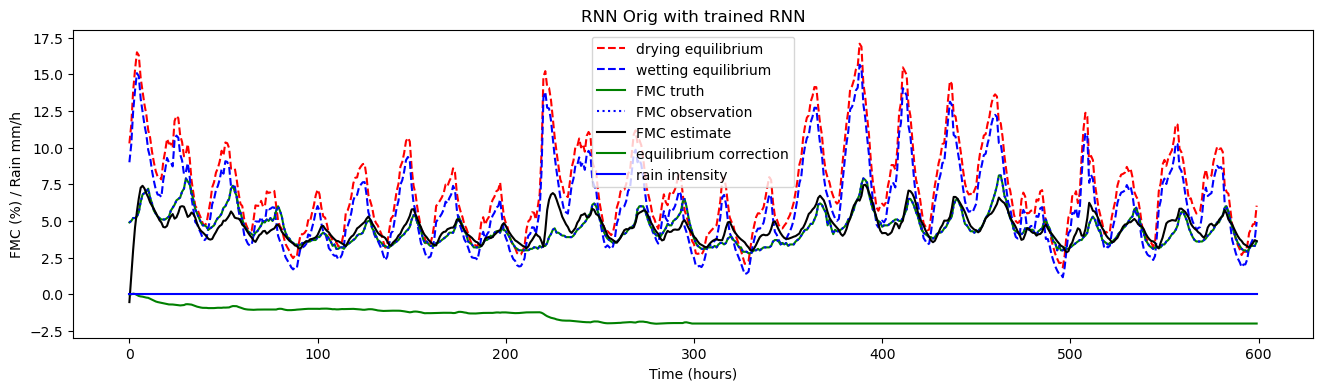

In [23]:
plot_data(case_data,title2='with trained RNN',hmin=0,hmax=600)


In [24]:
mse_data(case_data)

Training MSE:   0.6396
Prediction MSE: 0.5373


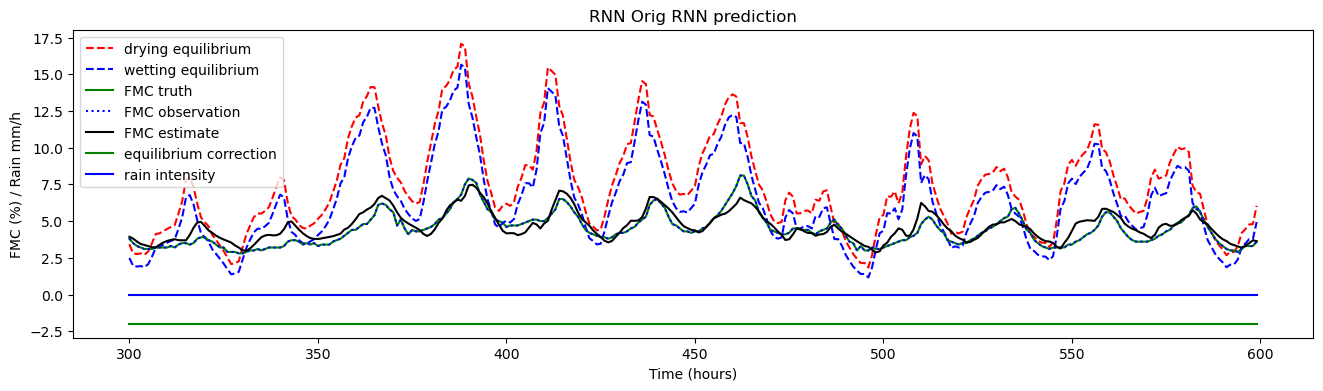

In [25]:
plot_data(case_data,title2='RNN prediction',hmin=300,hmax=600)

In [26]:
print(hash2(case_data['m']))
print(hash2(model_predict.get_weights()))
print(model_predict.get_weights())

380442441424371125
5.55077327554663e+19
[array([[ 0.31772935,  0.31592548,  0.32283914,  0.21918553,  0.01425408,
         0.01352852],
       [ 0.11898713,  0.11664673,  0.12561582, -0.00815092, -0.26398894,
        -0.26486528]], dtype=float32), array([[ 0.13386019,  0.13400266,  0.13345554,  0.14164959,  0.15859815,
         0.15866132],
       [ 0.13273151,  0.13288197,  0.13230488,  0.14097176,  0.15886803,
         0.15893526],
       [ 0.13704705,  0.13716622,  0.13670798,  0.14356348,  0.15783627,
         0.15789057],
       [ 0.06961801,  0.07022813,  0.06789105,  0.10308311,  0.17415857,
         0.1744147 ],
       [-0.08122178, -0.07954732, -0.08596081,  0.01162518,  0.2107843 ,
         0.2114987 ],
       [-0.08180267, -0.08012308, -0.08655183,  0.0112683 ,  0.21092236,
         0.21163873]], dtype=float32), array([0.9005663 , 0.90119946, 0.89877665, 0.9335469 , 0.99162567,
       0.9918006 ], dtype=float32), array([[-0.0140542 ],
       [-0.01177623],
       [-0.0205053

---
---

<mark>Start Here after Check 1<\mark>

In [27]:
reproducibility.set_seed()

resetting random seed do 123


Function: moisture_rnn.create_RNN_2
Arguments:
  hidden_units = 6
  dense_units = 1
  activation = ['linear', 'linear']
  stateful = True
  batch_shape = (296, 5, 2)
  input_shape = None
  dense_layers = 1
  rnn_layers = 1
  return_sequences = False
  initial_state = None
  verbose = True


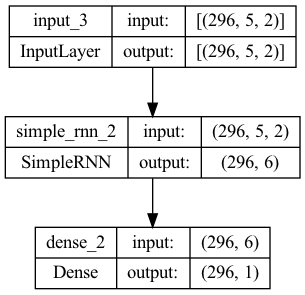

In [28]:
from utils import vprint

hours = rnn_dat['hours']
    
samples = rnn_dat['samples']
features = rnn_dat['features']
timesteps = rnn_dat['timesteps']
    
model_fit=create_RNN_2(hidden_units=6, 
                        dense_units=1, 
                        batch_shape=(samples,timesteps,features),
                        stateful=True,
                        return_sequences=False,
                        # initial_state=h0,
                        activation=['linear','linear'],
                        dense_layers=1)

from keras.utils.vis_utils import plot_model
plot_model(model_fit, to_file='model_plot.png', 
           show_shapes=True, show_layer_names=True)

In [29]:
## Check 2: Untrained RNN initialized with same weights

hash2(model_fit.get_weights())

2.7903911808504898e+19

In [30]:
Et = rnn_dat['Et']
model_predict=create_RNN_2(hidden_units=6, dense_units=1,  
                            input_shape=(hours,features),stateful = False,
                            return_sequences=True,
                            activation=['linear','linear'],dense_layers=1)

Function: moisture_rnn.create_RNN_2
Arguments:
  hidden_units = 6
  dense_units = 1
  activation = ['linear', 'linear']
  stateful = False
  batch_shape = None
  input_shape = (854, 2)
  dense_layers = 1
  rnn_layers = 1
  return_sequences = True
  initial_state = None
  verbose = True


In [31]:
## Check 3: Second model initialization same weights

hash2(model_predict.get_weights())

2.6078943006394597e+19

In [32]:
print(rnn_dat)
x_train = rnn_dat['x_train']
y_train = rnn_dat['y_train']
type(x_train)

# print dimensions and set initial state
print('model_fit input shape',x_train.shape,'output shape',model_fit(x_train).shape)

# fitting
DeltaE = 0
w_exact=  [np.array([[1.-np.exp(-0.1)]]), np.array([[np.exp(-0.1)]]), np.array([0.]),np.array([[1.0]]),np.array([-1.*DeltaE])]
    
w_initial=[np.array([[1.-np.exp(-0.1)]]), 
           np.array([[np.exp(-0.1)]]), 
           np.array([0.]),
           np.array([[1.0]]),
           np.array([-1.0])]
r = 1e-2
r = 0.
print('randomization of initial weights ',r)
w=model_fit.get_weights()
for i in range(len(w)):
    vprint('weight',i,'shape',w[i].shape,'ndim',w[i].ndim,'given',w_initial[i].shape)
    for j in range(w[i].shape[0]):
        if w[i].ndim==2:
            for k in range(w[i].shape[1]):
                w[i][j][k]=w_initial[i][0][0]/w[i].shape[0] + np.random.normal(0,1)*r
        else:
            w[i][j]=w_initial[i][0] + np.random.normal(0,1)*r
model_fit.set_weights(w)

{'hours': 854, 'x_train': array([[[10.28432339,  8.99874245],
        [11.55194608, 10.22120102],
        [13.86825543, 12.47869626],
        [15.3121617 , 13.90086965],
        [16.49195768, 15.07097053]],

       [[11.55194608, 10.22120102],
        [13.86825543, 12.47869626],
        [15.3121617 , 13.90086965],
        [16.49195768, 15.07097053],
        [16.28120182, 14.86079906]],

       [[13.86825543, 12.47869626],
        [15.3121617 , 13.90086965],
        [16.49195768, 15.07097053],
        [16.28120182, 14.86079906],
        [14.7368457 , 13.32877731]],

       ...,

       [[ 8.02306084,  6.81711472],
        [ 6.86940545,  5.70129998],
        [ 5.72966328,  4.62574073],
        [ 5.33547916,  4.24869236],
        [ 4.86325513,  3.80328611]],

       [[ 6.86940545,  5.70129998],
        [ 5.72966328,  4.62574073],
        [ 5.33547916,  4.24869236],
        [ 4.86325513,  3.80328611],
        [ 4.25725696,  3.24556671]],

       [[ 5.72966328,  4.62574073],
        [ 5.335

In [33]:
## Check 4: weights and inputs the same after this step 

print(hash2(model_fit.get_weights()))
print(hash2(x_train))
print(hash2(y_train))

3.735307973219784e+19
9270893620491725179
10119650379183749962


In [34]:
print('model_fit input shape',x_train.shape,'output shape',y_train.shape)
print('x_train',x_train)
print('y_train',y_train)

model_fit input shape (296, 5, 2) output shape (296, 1)
x_train [[[10.28432339  8.99874245]
  [11.55194608 10.22120102]
  [13.86825543 12.47869626]
  [15.3121617  13.90086965]
  [16.49195768 15.07097053]]

 [[11.55194608 10.22120102]
  [13.86825543 12.47869626]
  [15.3121617  13.90086965]
  [16.49195768 15.07097053]
  [16.28120182 14.86079906]]

 [[13.86825543 12.47869626]
  [15.3121617  13.90086965]
  [16.49195768 15.07097053]
  [16.28120182 14.86079906]
  [14.7368457  13.32877731]]

 ...

 [[ 8.02306084  6.81711472]
  [ 6.86940545  5.70129998]
  [ 5.72966328  4.62574073]
  [ 5.33547916  4.24869236]
  [ 4.86325513  3.80328611]]

 [[ 6.86940545  5.70129998]
  [ 5.72966328  4.62574073]
  [ 5.33547916  4.24869236]
  [ 4.86325513  3.80328611]
  [ 4.25725696  3.24556671]]

 [[ 5.72966328  4.62574073]
  [ 5.33547916  4.24869236]
  [ 4.86325513  3.80328611]
  [ 4.25725696  3.24556671]
  [ 3.63840045  2.68449383]]]
y_train [[5.3]
 [5.6]
 [6.3]
 [6.8]
 [6.9]
 [7. ]
 [7.2]
 [6.6]
 [6.2]
 [5.7]


In [35]:
reproducibility.set_seed()

resetting random seed do 123


In [36]:
model_fit.get_weights()

[array([[0.04758129, 0.04758129, 0.04758129, 0.04758129, 0.04758129,
         0.04758129],
        [0.04758129, 0.04758129, 0.04758129, 0.04758129, 0.04758129,
         0.04758129]], dtype=float32),
 array([[0.15080623, 0.15080623, 0.15080623, 0.15080623, 0.15080623,
         0.15080623],
        [0.15080623, 0.15080623, 0.15080623, 0.15080623, 0.15080623,
         0.15080623],
        [0.15080623, 0.15080623, 0.15080623, 0.15080623, 0.15080623,
         0.15080623],
        [0.15080623, 0.15080623, 0.15080623, 0.15080623, 0.15080623,
         0.15080623],
        [0.15080623, 0.15080623, 0.15080623, 0.15080623, 0.15080623,
         0.15080623],
        [0.15080623, 0.15080623, 0.15080623, 0.15080623, 0.15080623,
         0.15080623]], dtype=float32),
 array([0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[0.16666667],
        [0.16666667],
        [0.16666667],
        [0.16666667],
        [0.16666667],
        [0.16666667]], dtype=float32),
 array([-1.], dtype=float32)]

In [37]:
model_fit.fit(x_train, y_train, epochs=5000, verbose=2, batch_size=samples)
w_fitted=model_fit.get_weights()
for i in range(len(w)):
    vprint('weight',i,' exact:',w_exact[i],':  initial:',w_initial[i],' fitted:',w_fitted[i])
    
model_predict.set_weights(w_fitted)

Epoch 1/5000
1/1 - 1s - loss: 8.0507 - 1s/epoch - 1s/step
Epoch 2/5000
1/1 - 0s - loss: 3.5697 - 4ms/epoch - 4ms/step
Epoch 3/5000
1/1 - 0s - loss: 1.8481 - 4ms/epoch - 4ms/step
Epoch 4/5000
1/1 - 0s - loss: 1.1053 - 4ms/epoch - 4ms/step
Epoch 5/5000
1/1 - 0s - loss: 1.1652 - 4ms/epoch - 4ms/step
Epoch 6/5000
1/1 - 0s - loss: 1.3752 - 4ms/epoch - 4ms/step
Epoch 7/5000
1/1 - 0s - loss: 1.7570 - 4ms/epoch - 4ms/step
Epoch 8/5000
1/1 - 0s - loss: 2.0369 - 4ms/epoch - 4ms/step
Epoch 9/5000
1/1 - 0s - loss: 2.2623 - 4ms/epoch - 4ms/step
Epoch 10/5000
1/1 - 0s - loss: 2.4173 - 4ms/epoch - 4ms/step
Epoch 11/5000
1/1 - 0s - loss: 2.3845 - 4ms/epoch - 4ms/step
Epoch 12/5000
1/1 - 0s - loss: 2.2397 - 4ms/epoch - 4ms/step
Epoch 13/5000
1/1 - 0s - loss: 2.0768 - 4ms/epoch - 4ms/step
Epoch 14/5000
1/1 - 0s - loss: 1.8891 - 4ms/epoch - 4ms/step
Epoch 15/5000
1/1 - 0s - loss: 1.5833 - 4ms/epoch - 4ms/step
Epoch 16/5000
1/1 - 0s - loss: 1.4937 - 4ms/epoch - 4ms/step
Epoch 17/5000
1/1 - 0s - loss: 1.25

In [38]:
## Check 5: Weights NOT the same after fitting

hash2(model_fit.get_weights())

5.55077327554663e+19

In [39]:
model_fit.get_weights()

[array([[ 0.31772935,  0.31592548,  0.32283914,  0.21918553,  0.01425408,
          0.01352852],
        [ 0.11898713,  0.11664673,  0.12561582, -0.00815092, -0.26398894,
         -0.26486528]], dtype=float32),
 array([[ 0.13386019,  0.13400266,  0.13345554,  0.14164959,  0.15859815,
          0.15866132],
        [ 0.13273151,  0.13288197,  0.13230488,  0.14097176,  0.15886803,
          0.15893526],
        [ 0.13704705,  0.13716622,  0.13670798,  0.14356348,  0.15783627,
          0.15789057],
        [ 0.06961801,  0.07022813,  0.06789105,  0.10308311,  0.17415857,
          0.1744147 ],
        [-0.08122178, -0.07954732, -0.08596081,  0.01162518,  0.2107843 ,
          0.2114987 ],
        [-0.08180267, -0.08012308, -0.08655183,  0.0112683 ,  0.21092236,
          0.21163873]], dtype=float32),
 array([0.9005663 , 0.90119946, 0.89877665, 0.9335469 , 0.99162567,
        0.9918006 ], dtype=float32),
 array([[-0.0140542 ],
        [-0.01177623],
        [-0.02050531],
        [ 0.1096

In [40]:
model_fit.get_config()

{'name': 'model_2',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (296, 5, 2),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_3'},
   'name': 'input_3',
   'inbound_nodes': []},
  {'class_name': 'SimpleRNN',
   'config': {'name': 'simple_rnn_2',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': True,
    'unroll': False,
    'time_major': False,
    'units': 6,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'shared_object_id': 1},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None},
     'shared_object_id': 2},
    'bias_initializer': {'class_name': 'Zeros',
     'config': {},
     'shared_object_id': 3},
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bia

In [41]:
## RNN weights repeated in odd way that looks like untrained

model_fit.get_weights()

[array([[ 0.31772935,  0.31592548,  0.32283914,  0.21918553,  0.01425408,
          0.01352852],
        [ 0.11898713,  0.11664673,  0.12561582, -0.00815092, -0.26398894,
         -0.26486528]], dtype=float32),
 array([[ 0.13386019,  0.13400266,  0.13345554,  0.14164959,  0.15859815,
          0.15866132],
        [ 0.13273151,  0.13288197,  0.13230488,  0.14097176,  0.15886803,
          0.15893526],
        [ 0.13704705,  0.13716622,  0.13670798,  0.14356348,  0.15783627,
          0.15789057],
        [ 0.06961801,  0.07022813,  0.06789105,  0.10308311,  0.17415857,
          0.1744147 ],
        [-0.08122178, -0.07954732, -0.08596081,  0.01162518,  0.2107843 ,
          0.2114987 ],
        [-0.08180267, -0.08012308, -0.08655183,  0.0112683 ,  0.21092236,
          0.21163873]], dtype=float32),
 array([0.9005663 , 0.90119946, 0.89877665, 0.9335469 , 0.99162567,
        0.9918006 ], dtype=float32),
 array([[-0.0140542 ],
        [-0.01177623],
        [-0.02050531],
        [ 0.1096

In [42]:
# evaluate model
model_predict.set_weights(w_fitted)
x_input=np.reshape(Et,(1, hours, 2))
y_output = model_predict.predict(x_input)
print('x_input.shape=',x_input.shape,'y_output.shape=',y_output.shape)
# print(shift)
m = np.reshape(y_output,hours)
fitted_data = case_data.copy()
fitted_data.update({'m':m,'title':"First RNN forecast"})
del fitted_data['Ec']

1/1 [==============================] - 0s 243ms/step
x_input.shape= (1, 854, 2) y_output.shape= (1, 854, 1)


Training MSE:   0.6396
Prediction MSE: 0.5373


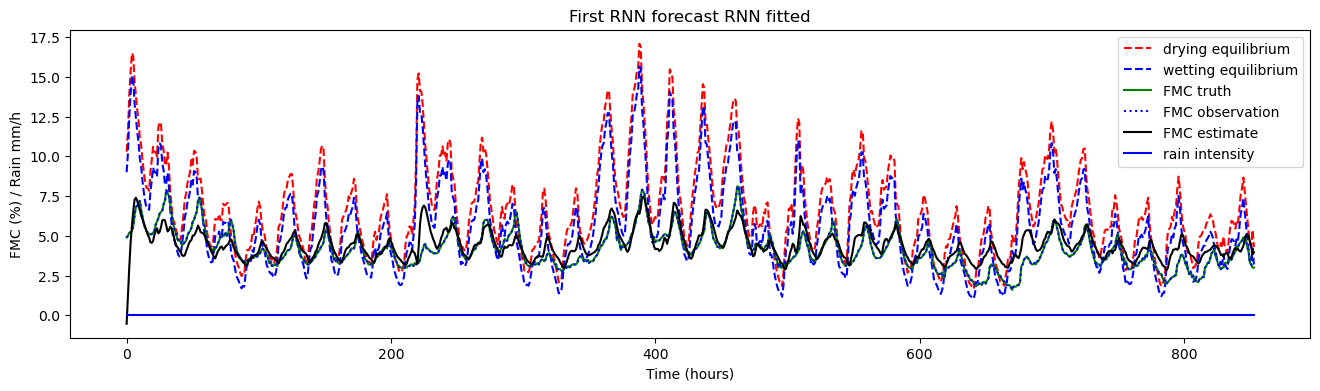

In [43]:
mse_data(fitted_data)
plot_data(fitted_data,title2='RNN fitted')